## **Load Dataset Files**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/drive/MyDrive/Datasets/vehicles.csv')

## **Dataset Preprocessing**

### Dropping Unnecessary Columns

In [2]:
column_to_drop = ['id','url','region_url','VIN', 'paint_color', 'image_url', 'description', 'county', 'region', 'state', 'lat', 'long']
df = df.drop(column_to_drop, axis=1)

### Handling Missing Values #1: Drop Rows With 50% Nulls
> Rows with more than 50% null values will be deleted, and rows with less than 50% null values wil be filled with mean value

In [3]:
#Identify null values with boolean true/false
print("There are", df.isnull().sum().sum(), "null values in the dataset. In details:")
df.isnull().sum()

There are 923975 null values in the dataset. In details:


price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
posting_date        68
dtype: int64

In [4]:
# Calculate the percentage of null values in each row using the sum and count methods:
null_percentages = df.isna().sum(axis=1) / df.shape[1] * 100
# Boolean mask to identify rows with more than 50% null values:
mask = null_percentages >= 50

In [5]:
# Drop rows with more than 50% null values
df = df.drop(df[mask].index, axis=0)

### Handling Categorical Data
> Using Label Encoding

In [27]:
# Split columns to categorical & numerical data
df_cat = df.select_dtypes(object)
df_num = df.select_dtypes(np.number)

In [28]:
# Loop through categorical columns and convert them to numerical using Label Encoding
for col in df_cat:
  le = LabelEncoder()
  df_cat[col] = le.fit_transform(df_cat[col])

In [29]:
# Concatenate the columns together in a single dataframe called df2
df2 = pd.concat([df_cat, df_num], axis=1)

### Handling Missing Values 2: Data Interpolation


In [30]:
# Interpolate the rest of the rows with mean values of each column

for col in df2.columns:
  if df2[col].isnull().any():
    # Calculate the mean of the non-null values
    col_mean = df2[col].mean()
    # Fill the null values with the mean
    df2[col] = df2[col].fillna(col_mean)

In [31]:
print("Original data null values", df.isnull().sum().sum())
print("Modified data null values", df2.isnull().sum().sum())

Original data null values 916345
Modified data null values 0


### Detect & Remove Outliers
> Using z-score method

In [32]:
# Remove rows which has outliers in any column using z-score method
def remove_outliers(data, threshold=3):
  # Calculate the z-scores
  z_scores = np.abs((data - data.mean()) / data.std())
  # Identify rows with outliers
  outliers = (z_scores > threshold).any(axis=1)
  # Remove rows with outliers
  cleaned_data = data[~outliers]

  return cleaned_data

# Call Remove outliers function
df3 = remove_outliers(df2)

### Unit all values datatype into float

In [33]:
df3 = df3.astype(float)

## **Divide the Dataset Into Training & Testing**
> using splitting ratio 80:20

In [34]:
from sklearn.model_selection import train_test_split

# Divide the dataset into features (X) and target variable (y)
x = df3.drop('price', axis=1)  # Features
y = df3['price']  # Target variable

In [35]:
# Add a new column of x0 with values of 1
from sklearn import preprocessing
x = preprocessing.scale(x)
x = np.c_[np.ones(x.shape[0]),x]
print("checking the new column:\n", x)

checking the new column:
 [[ 1.         -0.46244125  0.93324641 ...  1.60357333  0.28121224
  -0.53332357]
 [ 1.         -1.03269055  0.98391415 ...  1.60340124 -0.36463601
  -0.32843184]
 [ 1.         -1.03269055  0.98985276 ...  1.60370013  1.24998462
  -1.13021358]
 ...
 [ 1.         -1.11415473  1.56349752 ... -1.73978193  1.24998462
  -1.36097471]
 [ 1.          0.27073641 -0.43907862 ... -1.73979099  0.92706049
  -0.96156979]
 [ 1.         -1.2770831  -1.75037493 ... -1.73980005  1.08852256
  -1.0754567 ]]


In [36]:
# Split the data into training and testing sets with test size of 20%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [37]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (314201, 14)
x_test shape: (78551, 14)
y_train shape: (314201,)
y_test shape: (78551,)


## **Model Implementation**
> **Cost Function :** Mean Squared Error (MSE)

In [38]:
class MLinearRegression:
  # initial values
  def __init__(self, learning_rate, epochs):
    self.learning_rate = learning_rate
    self.epochs = epochs
    self.weights = None
    self.bias = None
    # to Keep a record of the cost at each iteration
    self.cost_record = []

  # Fit the model
  def fit(self, x, y):
      # x rows = samples, x columns = features
      n_samples, n_features = x.shape
      # Initialize Bias
      self.bias = 0
      # Initialize all weights with random numbers, where the vector size is equal to the number of features
      self.weights = np.random.randn(n_features)

      for i in range(self.epochs):
        # Dot product of x with Transpose of weights, if bias is considered then add it +self.bias
        y_predict = np.dot(x, self.weights.T) + self.bias
        # Calculate the error difference
        difference = y - y_predict
        # Calculate Cost using MSE and add it to the cost record
        cost = (1/n_samples)*np.sum(np.square(difference))
        self.cost_record.append(cost)
        # Compute Gradient
        gradientD = (-2/n_samples)*np.dot(x.T, difference)
        # Update Parameters
        self.weights = self.weights - self.learning_rate*gradientD

  # Predict
  def predict(self, x):
    return np.dot(x, self.weights)

## **Model Training**
> **learning rate :** 𝜶=0.1,
> **Epochs :** 10 epochs

In [39]:
linearRegression = MLinearRegression(0.1, 10) # Learnng_rate = 0.1, Epochs = 10
linearRegression.fit(x_train, y_train)

## **Model Performance Testing**
> Computing and reporting the MSE on the testset

In [40]:
# Compute MSE of the test set
y_predict = linearRegression.predict(x_test)
MSE_test = np.mean((y_test - y_predict) ** 2)
# Report MSE of the test set
print("Mean Squared Error (MSE) of the test set is:", MSE_test, "\n")

# print("Calculated weights:", linearRegression.weights,"\n")   <-- Uncomment to display the final weights
# print("Cost Record:", linearRegression.cost_record)           <-- Uncomment to display the costs record

Mean Squared Error (MSE) of the test set is: 4116449619.392749 



## **Results Analysis**

### Plotting Cost vs. Iterations

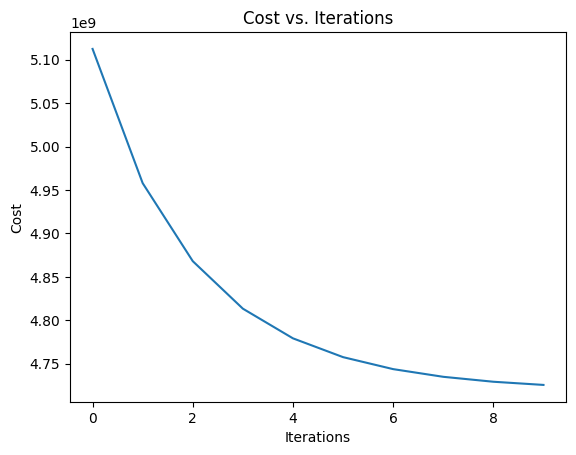

In [41]:
# Plot the cost record v. iterations
plt.plot(range(linearRegression.epochs), linearRegression.cost_record)

# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.title('Cost vs. Iterations')

# Show the plot
plt.show()

### Most Significant Features

In [44]:
# Remove the first column values that contains x0 values and its coefficients
df4 = df3.drop('price', axis=1)
feature_names = df4.columns
coefficients = linearRegression.weights[1:]

# Create a DataFrame with features and coefficients
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute values of coefficients in descending order
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Print the 5 most significant features
print("Most Significant Features Are\n")
for index, row in coef_df.head(5).iterrows():
    print(f"{index+1}) {row['Feature']}: {row['Coefficient']:.2f}")

Most Significant Features Are

12) year: 4025.58
13) odometer: -3345.87
7) transmission: 2101.88
5) fuel: -2092.22
4) cylinders: 1602.82
